In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from functions import get_dyn_v2, get_prop_abs_v2, create_R_v1, get_var_hist,simulate_traj,get_prop_abs, create_R, get_theo_var_l, get_x2_var
from setup import setup_matplotlib
#from scipy.linalg import expm
#from scipy.sparse import csr_array, coo_array
from scipy.optimize import curve_fit

setup_matplotlib()

np.random.seed(42)

In [ ]:
# def fit_rate(x, a,b):
#     return 1/2+1/2*np.exp(-a*(x-b))

In [4]:
k = 1
s = 0.2
border = 1
N_x_border = 6.5
max_t = 10
ntau = 3

D = s**2/2

dx = border/N_x_border
sb = 17.5*dx #with .5, 0 not included

f = 4
N_p = 2_000
N_loop = 10
eq_perc = 0.75
eq_f = 0.75


x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
i_zero = np.argmin((x_s+border)**2)
N_x = len(x_s)


def cusp_force(x, thresh = 1e-7):
    if x < -thresh:
        return -k*(x+border)
    elif x > thresh:
        return -k*(x-border)
    else:
        return 0
force = np.vectorize(cusp_force)




ltaus = np.concatenate(([0.05], np.arange(0.2,2.2,0.2) ))

test_ts = np.linspace(0,max_t, 4000)
exact_eqtimes = [test_ts[np.argmin((get_theo_var_l(test_ts,ltau,D) - eq_perc*get_x2_var(ltau, k, s))**2)] for ltau in ltaus]

In [ ]:
num_rates = np.empty((len(ltaus),2))
sim_rates = np.empty((len(ltaus),2))

for i,ltau in enumerate(tqdm(ltaus)): 
    ldt = ltau/ntau
    q_f = np.log(1-eq_f)/np.log(1-eq_perc)
    rel_time = q_f*exact_eqtimes[i]
    
    
    
    N_t = max(int(2*rel_time/ldt),int(max_t/ldt), 30)
    ts = np.arange(0,N_t)*ldt
    sim_ts = np.arange(0,f*N_t+ntau*f)*ldt/f-ltau
    
    pos = simulate_traj(N_p=N_p, N_loop=N_loop, N_t=(N_t+ntau)*f, ntau=ntau*f, s=s, dt=ldt/f,border=border, force=force)
    print(np.min(pos), np.min(pos)/x_s[0])
    
    sim_hists = np.swapaxes(np.apply_along_axis(lambda a: np.histogram(a, bins)[0], 1, pos), 1,2)
    prop = get_prop_abs_v2(x_s, force,D,ldt,dx)
    R, _, end_states = create_R_v1(N_x, ntau, prop)
    _, hists = get_dyn_v2(R, i_zero,N_t, N_x, ntau, end_states)

    num_sur = np.sum(hists[:,x_s < 0], axis = 1)/np.sum(hists, axis = 1)
    sim_sur = np.sum(sim_hists[:,:,x_s < 0], axis = 2)/np.sum(sim_hists, axis = 2)
    
    sim_cond = (sim_ts > rel_time) * (sim_sur - 1/2 > 0.05)
    num_cond = (ts > rel_time) * (num_sur - 1/2 > 0.05)
    
    sim_rate = [-np.mean(np.diff(np.log(2*sim_sur[i,this_sim_cond]-1))/ldt*f) for i,this_sim_cond in enumerate(sim_cond)]
    num_rate = -np.mean(np.diff(np.log(2*num_sur[num_cond]-1))/ldt)
    
    sim_rates[i] = (np.mean(sim_rate), np.std(sim_rate)/np.sqrt(N_loop))
    num_rates[i] = (num_rate, 0)
    

    
#    sim_cond = (sim_ts > 2*ltau) * (sim_sur - 1/2 > 0.05)
#    num_cond = (ts > 2*ltau) * (num_sur - 1/2 > 0.05)
#     if np.sum(sim_cond) > 4 and np.sum(num_cond) > 4:
#         sim_popt, sim_pcov = curve_fit(fit_rate, sim_ts[sim_cond], sim_sur[sim_cond])
#         num_popt, num_pcov = curve_fit(fit_rate, ts[num_cond], num_sur[num_cond])

#         num_rates[i] = (num_popt[0], np.sqrt(num_pcov[0,0]))
#         sim_rates[i] = (sim_popt[0], np.sqrt(sim_pcov[0,0]))
#     else:
#         num_rates[i] = (np.nan, np.nan)
#         sim_rates[i] = (np.nan, np.nan)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

-1.729163160720656 0.6422606025533865


  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

-1.7744094867419649 0.6590663807898726


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

-1.8490127830376053 0.6867761765568248


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

-2.006835349290667 0.7453959868793906


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

-2.1755325777540007 0.8080549574514859


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

-2.377860169506651 0.883205205816756


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

-2.518284512479222 0.9353628189208538


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

-3.0816965912491177 1.1446301624639579


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

-2.8915467343593635 1.0740030727620493


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

-3.361175711953081 1.2484366930111443


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

-3.522380110425505 1.3083126124437587


  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
with open(f'nummeric_results/cusp_rate_s{s}.pkl', 'wb') as file:
    pickle.dump({'ltaus':ltaus,
                 'num_rates':num_rates,
                'sim_rates':sim_rates
                }, file)

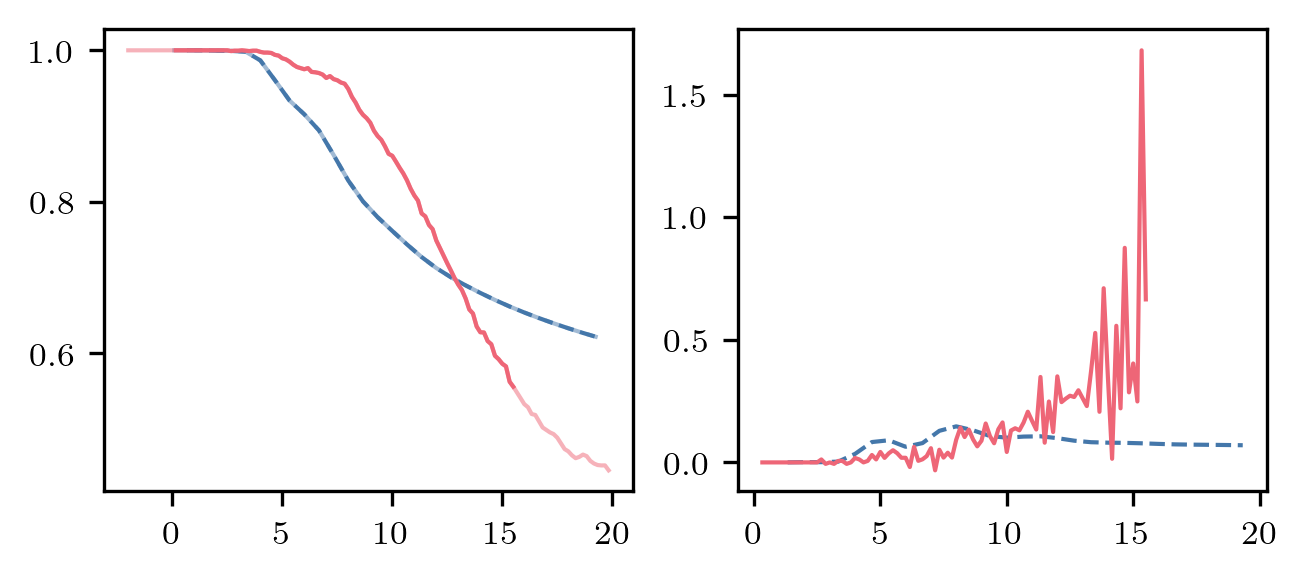

In [ ]:
idx = 3
plt.figure(figsize=(5,2))
plt.subplot(121)
plt.plot(ts,num_sur, color = 'C0', ls = '--', alpha =.5)
plt.plot(ts[num_cond],num_sur[num_cond], color = 'C0', ls = '--')
plt.plot(sim_ts,sim_sur[idx], color = 'C1', alpha= .5)
plt.plot(sim_ts[sim_cond[idx]],sim_sur[idx][sim_cond[idx]], color = 'C1')
plt.ylim(*plt.ylim())
plt.subplot(122)
#plt.plot(ts[1:],np.diff(np.log(2*num_sur-1))/ldt, color = 'C0', ls = '--', alpha =.5)
plt.plot(ts[num_cond][1:],-np.diff(np.log(2*num_sur[num_cond]-1))/ldt, color = 'C0', ls = '--')
#plt.plot(sim_ts[1:],np.diff(np.log(2*sim_sur[idx]-1))/ldt*f, color = 'C1', alpha= .5)
plt.plot(sim_ts[sim_cond[idx]][1:],-np.diff(np.log(2*sim_sur[idx][sim_cond[idx]]-1))/ldt*f, color = 'C1')

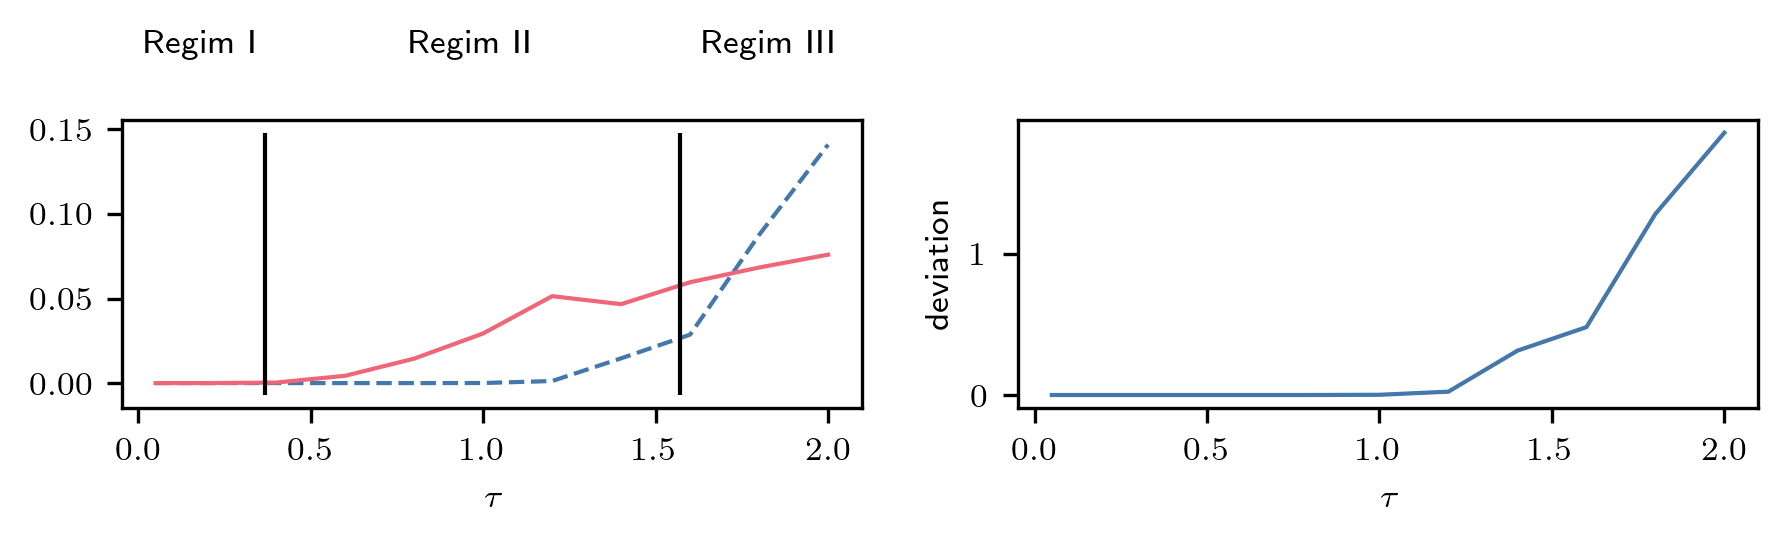

In [ ]:
plt.figure(figsize=(6,2))
plt.subplot(121)
plt.plot(ltaus, num_rates[:,0], '--')
plt.plot(ltaus, sim_rates[:,0])


#plt.xlim(0,2.1)
#plt.ylim(1e-3,1)

plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
y = 0.2
plt.text(0.5*1/np.e /k,              y,'Regim I', ha='center', va='center')
plt.text(0.5*(1/np.e /k+  np.pi/2/k),y,'Regim II',ha='center', va='center')
plt.text(0.5*(np.pi/2/k + plt.xlim()[1]),            y,'Regim III',ha='center', va='center')
plt.xlabel(r'$\tau$')
#plt.ylabel('1/rate')
#plt.yscale('log')

plt.subplot(122)

plt.plot(ltaus, num_rates[:,0]/sim_rates[:,0])
plt.xlabel(r'$\tau$')
plt.ylabel('deviation')
plt.tight_layout()
#plt.savefig(f'graphics/cusp_rates_s{s}.pdf')

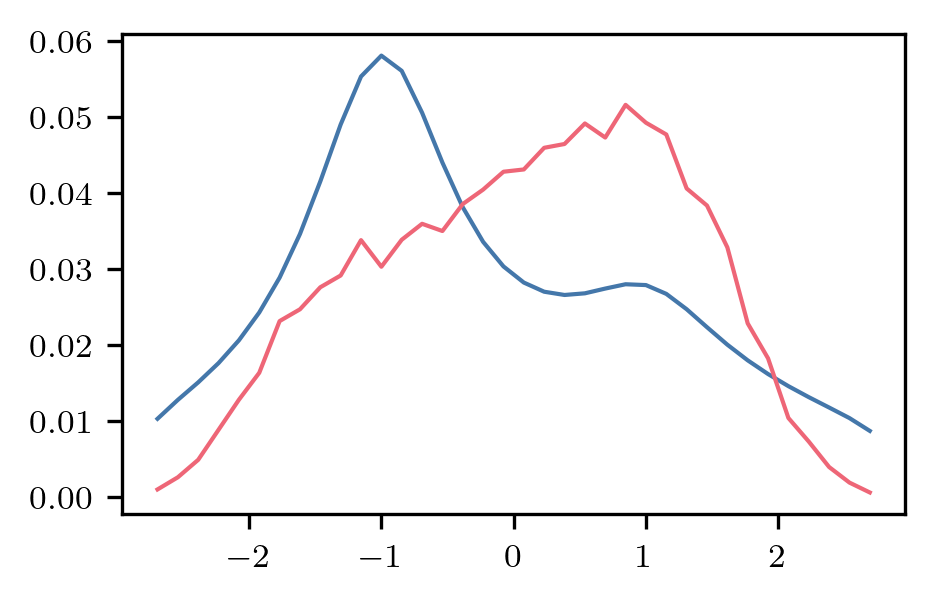

In [ ]:
t_hist = sim_hists.sum(0)
plt.plot(x_s,hists[-1]/hists[-1].sum())
plt.plot(x_s,t_hist[-1]/t_hist[-1].sum())